# Phonopy in Python

Maintainer: Zekun Lou

This notebook provides a straightforward guide to using `phonopy` in Python scripts with graphite as example.

It serves as a starting point for those who want to avoid the black box of `phonopy` shell commands, and prefer to integrate `phonopy` into their own Python scripts for customizing workflows.


Although this document is fairly detailed, **the core Python code is concise** (no more than some `import`s and simple function calls). The additional content is included to enhance clarity and provide better explanations. You can copy and modify the code snippets to fit your specific needs.

The **workflow** is as follows:

1. Converge the k-grid for the primitive cell and relax the primitive cell by `FHI-aims`.
1. Generate supercells with displacements using `phonopy`.
1. Perform force calculations for each supercell using `FHI-aims`.
1. Extract forces and construct force constants by `phonopy`.
    - This serves as a milestone for post-processing.
1. Compute the phonon band structure using `phonopy`.

The project’s **file structure** is as follows:

```text
${PROJECT_ROOT}
├── fd_runs
│   ├── sc_3  # for example, supercell size 3x3x3
│   │   ├── aims_runs
│   │   │   └── {0..${n}}  # directories for each run
│   │   ├── geoms_disp
│   │   │   └── {0..${n}}.xyz
│   │   ├── logs
│   │   ├── control.force.in  # for FHI-aims force calculation
│   │   ├── force_constants.h5  # force_constants hdf5 file saved by phonopy
│   │   ├── phono_bandstr.meV.png  # phonon band structure plot
│   │   └── phonopy_params.yaml  # phonopy meta-settings for this calculation
│   └── sc_${sc}  # other supercell sizes
├── relax_cell  # dir for cell relaxation calculations
│   └── relaxed.xyz  # the relaxed cell
└── phonopy_in_python.ipynb  # this file
```


In [11]:
""" change dir to ensure the file relative paths """
import os

PROJECT_ROOT = os.getcwd()
if PROJECT_ROOT.endswith("docs/source"):
    PROJECT_ROOT = os.path.join(PROJECT_ROOT, "phonopy_simple")
elif PROJECT_ROOT.endswith("phonopy_simple"):
    pass
print(PROJECT_ROOT)

/home/zekunlou/Projects/docs_howtos/docs/source/phonopy_simple


In [4]:
import matplotlib.pyplot as plt
import numpy
from ase.atoms import Atoms as aseAtoms
from ase.io import read, write
from ase.build import make_supercell

import h5py
from phonopy import Phonopy
from phonopy.cui.load import load as load_phonopy
from phonopy.file_IO import read_force_constants_hdf5, write_force_constants_to_hdf5
from phonopy.phonon.band_structure import get_band_qpoints_and_path_connections
from phonopy.structure.atoms import PhonopyAtoms

In [5]:
""" prepare useful functions """

def atoms_ase2ph(atoms: aseAtoms):
    if not numpy.all(atoms.get_pbc()):
        print("WARNING: for PhonopyAtoms the pbc must be T T T. Set to T T T.")
    return PhonopyAtoms(
        symbols=atoms.get_chemical_symbols(),
        cell=atoms.get_cell().array,
        positions=atoms.get_positions(),
    )

def atoms_ph2ase(atoms: PhonopyAtoms):
    return aseAtoms(
        symbols=atoms.symbols,
        cell=atoms.cell,
        positions=atoms.positions,
        pbc=True,
    )

## Generate finite difference structures

In [6]:
""" prepare parameters """

supercell = 5
work_dpath = f"{PROJECT_ROOT}/fd_runs/sc_{supercell}"
displacement = 1e-2
xyz_eq_fpath = f"{PROJECT_ROOT}/relax_cell/relaxed.xyz"

""" prepare directories and files """

geoms_dpath = f"{work_dpath}/geoms_disp"
aims_dpath = f"{work_dpath}/aims_runs"
logs_dpath = f"{work_dpath}/logs"
phonpy_params_fpath = f"{work_dpath}/phonopy_params.yaml"
force_constants_fpath = f"{work_dpath}/force_constants.h5"
band_structure_fpath = f"{work_dpath}/band_structure.h5"
[os.makedirs(dpath, exist_ok=True) for dpath in (geoms_dpath, aims_dpath, logs_dpath)]
atoms_prim = read(xyz_eq_fpath)

""" better load from phonopy_params.yaml for reproducibility """

if os.path.exists(phonpy_params_fpath):
    phonon = load_phonopy(phonpy_params_fpath)
    print(f"Loaded phonopy parameters from {phonpy_params_fpath}")
else:
    phonon = Phonopy(
        unitcell=atoms_ase2ph(atoms_prim),
        supercell_matrix=numpy.eye(3, dtype=int) * supercell,
    )
    phonon.generate_displacements(distance=displacement)
    phonon.save(phonpy_params_fpath)

""" write the displaced supercells for FHI-aims calculation """
""" for MLIPs: you can directly produce the force_sets with shape (n_supercells, n_atoms, 3), as the next cell """
for i, this_sc in enumerate(phonon.supercells_with_displacements):
    write(f"{geoms_dpath}/{i}.xyz", atoms_ph2ase(this_sc))
    os.makedirs(f"{aims_dpath}/{i}", exist_ok=True)
    write(f"{aims_dpath}/{i}/geometry.in", atoms_ph2ase(this_sc), format="aims")

Loaded phonopy parameters from /home/zekunlou/Projects/docs_howtos/docs/source/phonopy_simple/fd_runs/sc_5/phonopy_params.yaml


## Calculate or load force constants

In [7]:
""" load force constants and save it h5, because it could be slow, especially for large supercells and repeated calculations """

if os.path.exists(force_constants_fpath):
    phonon.force_constants = read_force_constants_hdf5(force_constants_fpath)
    print(f"Loaded force constants from {force_constants_fpath}")
else:
    """Load from aims output. Please rewrite this part for your own code."""
    force_sets = numpy.array([
        read(os.path.join(f"{aims_dpath}/{task_idx}/aims.out"), format="aims-output").get_forces()
        for task_idx in sorted(os.listdir(aims_dpath), key=lambda x: int(x))
    ])
    phonon.produce_force_constants(
        forces=force_sets,
        calculate_full_force_constants=False,
    )  # we are generating compact force constants here
    write_force_constants_to_hdf5(
        phonon.get_force_constants(),
        filename=force_constants_fpath,
    )
print(f"{phonon.force_constants.shape=}")

Loaded force constants from /home/zekunlou/Projects/docs_howtos/docs/source/phonopy_simple/fd_runs/sc_5/force_constants.h5
phonon.force_constants.shape=(4, 500, 3, 3)


## Plot and save phonon band structure

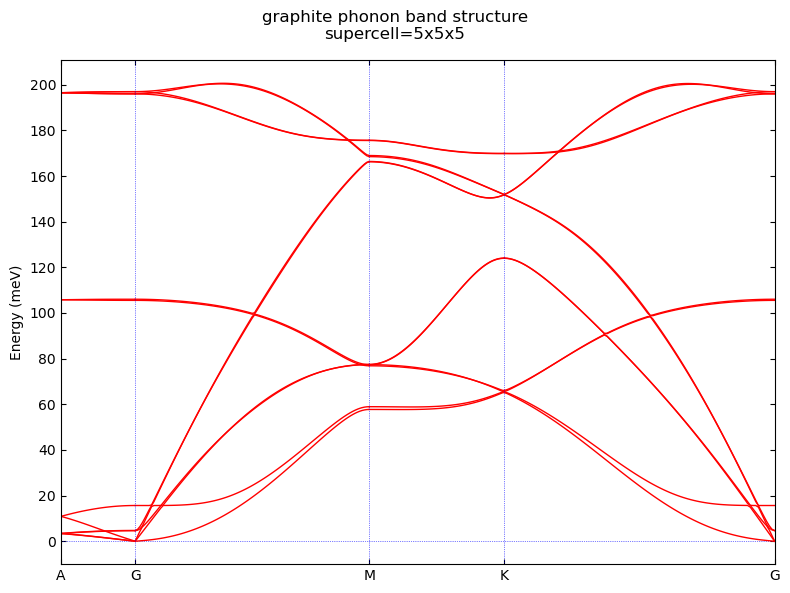

In [8]:
""" calculate phonon band structure """

special_points = {  # for hexagon cell with gamma = 60.0 deg
    "G": [0.0, 0.0, 0.0],
    "M": [1 / 2, 1 / 2, 0.0],
    "K": [1 / 3, 2 / 3, 0.0],
    "A": [0.0, 0.0, 1 / 2],
}

bz_labels = ["A", "G", "M", "K", "G"]
kpath = [[special_points[label] for label in bz_labels]]  # must be 2-level list
kpts, connections = get_band_qpoints_and_path_connections(kpath, npoints=101)

phonon.run_band_structure(kpts, path_connections=connections, labels=bz_labels)
# phonon.write_hdf5_band_structure(filename=band_structure_fpath)  # full band str too large, just GK

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
phonon._band_structure.plot([ax])  # a hack here, should be List[Axes]
xscale_factor = (
    max([numpy.max(fq) for fq in phonon._band_structure.frequencies])
    / phonon._band_structure.distances[-1][-1]
    * 1.5
)  # this can be found in phonopy src code
for d in phonon._band_structure.distances:
    ax.axvline(d[-1] * xscale_factor, color="b", linestyle=":", linewidth=0.5)

ax_unit = ["meV", "cm-1", "THz"][0]  # choose your preferred unit
if ax_unit == "meV":
    ax.set_ylabel("Energy (meV)")
    ax.set_ylim(ax.get_ylim())
    ax_yticks_in_meV = numpy.arange(0, 220, 20)
    ax.set_yticks(ax_yticks_in_meV / 4.1357, ax_yticks_in_meV)
elif ax_unit == "cm-1":
    ax_yticks_in_cm = numpy.arange(0, 1800, 200)
    ax.set_yticks(ax_yticks_in_cm / 4.1357 / 8.1, ax_yticks_in_cm)
    ax.set_ylabel("Frequency (cm$^{-1}$)")
elif ax_unit == "THz":
    ax.set_ylabel("Frequency (THz)")
else:
    raise ValueError(f"Unknown ax_unit: {ax_unit}")

fig.suptitle(
    f"graphite phonon band structure\nsupercell={supercell}x{supercell}x{supercell}"
)
fig.tight_layout()
fig = plt.gcf()
fig.savefig(f"{work_dpath}/phonon_bandstr.{ax_unit}.png", dpi=300, transparent=True)


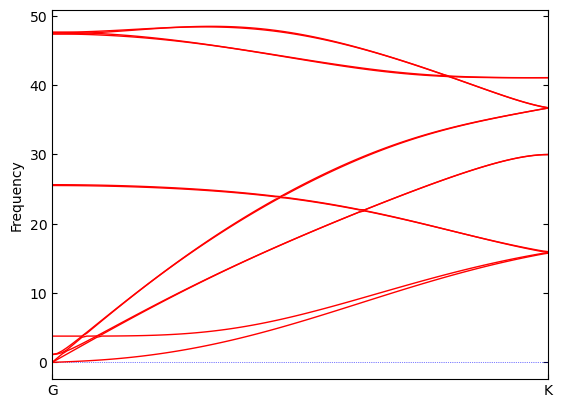

In [9]:
"""save for visualization"""
bz_labels = ["G", "K",]
kpath = [[special_points[label] for label in bz_labels]]  # must be 2-level list
kpts, connections = get_band_qpoints_and_path_connections(kpath, npoints=101)

phonon.run_band_structure(kpts, path_connections=connections, labels=bz_labels, with_eigenvectors=True,)
phonon.write_hdf5_band_structure(filename=f"{work_dpath}/band_structure.GK.h5")
phonon._band_structure.plot([plt.gca()])

## Phonon mode visualization

In [10]:
"""
in phonopy.harmonics.dynamical_matrix.DynamicalMatrix._run_py_dynamical_matrix,
the phase factor is phase.append(np.vdot(vec, q) * 2j * np.pi)  # positive sign
"""

def generate_phonon_visuals(
    atoms: aseAtoms,
    ph_eigvec: numpy.ndarray,
    k: numpy.ndarray,
    supercell: numpy.ndarray,
    num_frames: int = 16,
    amp_factor: float = 1.0,  # mass-scaling factor
    comment: str = "",
) -> list:
    """
    Generate phonon frames for visualization.
    For postprocessing phonopy output for visualization.

    Note:
        The phonon eigenvectors should be like phonopy, i.e. bloch phase applied to each atom but not unit cell.

    Args:
        atoms (ase.atoms.Atoms): The atomic structure.
        ph_eigvec (numpy.ndarray): Phonon eigenvector, better from phonopy.
        k (numpy.ndarray): Wave vector contains the 2*pi factor.
        supercell (numpy.ndarray): Supercell transformation matrix.
        num_frames (int, optional): Number of frames to generate. Defaults to 16.
        amp_factor (float, optional): Amplitude scaling factor. Defaults to 1.0.
        comment (str, optional): Comment to add to each frame. Defaults to "".

    Returns:
        list: List of Atoms objects representing the frames.

    Reference:
        Eq.27 in A. Togo, L. Chaput, T. Tadano, and I. Tanaka, Implementation strategies in phonopy and phono3py,
        J. Phys.: Condens. Matter 35, 353001 (2023).
    """
    assert ph_eigvec.ndim == 1, f"ph_eigvec should be a 1D array, but got {ph_eigvec.ndim}D"
    assert ph_eigvec.size == len(atoms) * 3, \
        f"ph_eigvec size should be (natoms * 3)=({len(atoms) * 3}), but got {ph_eigvec.size}"
    assert supercell.ndim == 2 and supercell.shape[0] == supercell.shape[1] == 3, \
        f"supercell should be a 3x3 matrix, but got shape {supercell.shape}"

    # Generate the supercell
    supercell_atoms = make_supercell(atoms, supercell)
    sc_positions = supercell_atoms.get_positions()

    # Repeat phonon eigenvector for the supercell
    natoms = len(atoms)
    sc_eigvec = numpy.tile(ph_eigvec.reshape(natoms, 3), (len(supercell_atoms) // natoms, 1))  # shape (n_sc_atoms, xyz)

    # Apply Bloch phase correction for each atom in the supercell
    bloch_phase_factor = numpy.exp(1j * (sc_positions @ k))[:, None]  # shape (n_sc_atoms, 1)

    # Apply Bloch phase to eigenvector
    sc_eigvec = (sc_eigvec * bloch_phase_factor)

    # Compute phonon displacements
    ph_phase = numpy.angle(sc_eigvec)  # shape (n_sc_atoms, xyz)
    ph_amp = amp_factor * numpy.abs(sc_eigvec) * (supercell_atoms.get_masses()**(-0.5))[:, None]  # shape (n_sc_atoms, xyz)
    ph_disp_time = numpy.linspace(0, 2 * numpy.pi, num_frames)  # omega*t for one period

    # Calculate displacements for each frame
    ph_disp = ph_amp[None, :] * numpy.sin(
        ph_phase[None, :] + ph_disp_time[:, None, None]
    )  # shape (n_frames, n_sc_atoms, xyz)

    # Generate frames
    ph_frames = []
    for i in range(num_frames):
        this_atoms = supercell_atoms.copy()
        this_atoms.positions = sc_positions + ph_disp[i]
        this_atoms.info["comment"] = comment
        ph_frames.append(this_atoms)

    return ph_frames


In [13]:
work_dpath = f"{PROJECT_ROOT}/fd_runs/sc_5"
atoms = read(f"{PROJECT_ROOT}/relax_cell/relaxed.xyz")

with h5py.File(f"{work_dpath}/band_structure.GK.h5", "r") as h5:
    # show the keys and arrays in the h5 file
    print(h5.keys())
    for k in h5.keys():
        if h5[k].size < 10:
            print(f"{k=}, shape={h5[k].shape}, content={h5[k][()]}")
        else:
            print(f"{k=}, shape={h5[k].shape}")
        if k == "frequency":
            data = h5[k][()]
    ph_kpath_frac = h5["path"][0,:]
    ph_eigvals = h5["frequency"][0,:]
    ph_eigvecs = h5["eigenvector"][0,:]  # shape (n_kpoints, n_atoms*3, n_bands/n_modes)
ph_kpath = ph_kpath_frac @ atoms.cell.reciprocal()  # without the 2pi factor
print(f"{ph_eigvals.shape=}, {ph_eigvecs.shape=}, {ph_kpath.shape=}")

# Example usage
os.makedirs(ph_viz_dpath:=f"{PROJECT_ROOT}/fd_runs/sc_5/ph_GK_viz_sc", exist_ok=True)
supercell_matrix = numpy.array([[10, 0, 0], [0, 10, 0], [0, 0, 1]])  # Example 10x10x1 supercell

kpt_idx, band_idx = 10, 2
for band_idx in (2, 3):  # TA and TA(antisymm) mode
    ph_eigvec = ph_eigvecs[kpt_idx][:, band_idx]
    ph_frames = generate_phonon_visuals(
        atoms,
        ph_eigvec,
        k=2 * numpy.pi * ph_kpath[kpt_idx],  # Convert k-point to reciprocal space
        supercell=supercell_matrix,
        comment=f"seg=GK,kpt_idx={kpt_idx},band_idx={band_idx}"
    )
    write(f"{ph_viz_dpath}/GK_kpt_{kpt_idx}_band_{band_idx}.xyz", ph_frames)


<KeysViewHDF5 ['distance', 'eigenvector', 'frequency', 'label', 'nqpoint', 'path', 'segment_nqpoint']>
k='distance', shape=(1, 101)
k='eigenvector', shape=(1, 101, 12, 12)
k='frequency', shape=(1, 101, 12)
k='label', shape=(1, 2), content=[[b'G' b'K']]
k='nqpoint', shape=(1,), content=[101]
k='path', shape=(1, 101, 3)
k='segment_nqpoint', shape=(1,), content=[101]
ph_eigvals.shape=(101, 12), ph_eigvecs.shape=(101, 12, 12), ph_kpath.shape=(101, 3)


Then you can put the frames into OVITO ([docs on rendering](https://www.ovito.org/manual/usage/rendering.html)) or VMD for visualization.
After rendering by OVITO and concatenating by ffmpeg, we get

For TA (transverse acoustic) mode:

![phonon_mode_TA.gif](./fd_runs/sc_5/ph_GK_viz_sc/GK_kpt_10_band_2.gif)

For T $\!\!\tilde{A}$ (transverse acoustic anti-symmetric) mode:

![phonon_mode_TAantisymm.gif](./fd_runs/sc_5/ph_GK_viz_sc/GK_kpt_10_band_3.gif)

Or OVITO python script for rendering.

OVITO provides different renderers, and git output timing benchmark:
```text
OpenGLRenderer: 0.78 s
TachyonRenderer: 16.09 s
OSPRayRenderer: 53.30 s
```
Also OpenGL is the fastest, the output quality is ill.
Maybe Tachyon is the best choice for rendering.

In [21]:
from ovito.io import import_file
# from ovito.data import *
from ovito.vis import Viewport
from ovito.vis import OpenGLRenderer, TachyonRenderer, OSPRayRenderer

kpt_idx, band_idx = 10, 2
pipeline = import_file(
    f"{ph_viz_dpath}/GK_kpt_{kpt_idx}_band_{band_idx}.xyz",
    columns = ["Particle Type", "Position.X", "Position.Y", "Position.Z"],
)
pipeline.add_to_scene()
atoms_frame_0 = read(f"{ph_viz_dpath}/GK_kpt_{kpt_idx}_band_{band_idx}.xyz", index=0)
center = atoms_frame_0.positions.mean(axis=0)
camera_pos_from_center = numpy.array((1, -1, 1))
vp = Viewport(
    type=Viewport.Type.Ortho,
    camera_pos = tuple(center + camera_pos_from_center),
    camera_dir=tuple(-camera_pos_from_center),  # look backwards to the center
)
vp.zoom_all()
vp.render_anim(
    size=(800,600),
    filename=f"{ph_viz_dpath}/GK_kpt_{kpt_idx}_band_{band_idx}.tachyon.gif",
    background=(1,1,1),
    fps=16,
    renderer=TachyonRenderer(),
)

For TA (transverse acoustic) mode rendered by OpenGL:

![phonon_mode_TA.opengl.gif](./fd_runs/sc_5/ph_GK_viz_sc/GK_kpt_10_band_2.opengl.gif)

For TA (transverse acoustic) mode rendered by Tachyon:

![phonon_mode_TA.tachyon.gif](./fd_runs/sc_5/ph_GK_viz_sc/GK_kpt_10_band_2.tachyon.gif)